# Programmatically generating training datasets
Previously I built the training data by manually taking several screenshots of the starter board on lichess using different themes, and upscaling/downscaling the screen view in chrome. Then using `tensorflow_chessbot.py` to split up these images into tiles with the known starter configuration for labels. This is not covering the space very well. With that data we built a basic model that is around 98% accurate for a few lichess boards in the starter configuration. 

Though the tiles shouldn't care where on the board they are, it may introduce image artifacts that could confuse the final neural network. To solve this, we need to generate training data in several configurations.

Ideally we'd like to generate our own FEN, and get an actual website board screenshot from it. Since a FEN provides the piece locations, we have our labels and our real data. We can use our same computer vision algorithm to split up the screenshots into tiles which will be fed into our neural network as training data.

## Generating random FENs

FEN stands for [Forsyth-Edwards Notation](https://en.wikipedia.org/wiki/Forsyth%E2%80%93Edwards_Notation), which is a dead simple way of encoding a single board layout. It's a string containing 8 sections divided by a `/` corresponding to descending files, and each section contains a character signifying the piece on that rank's square. A number signifies the number of empty spaces between pieces, so say `5p1Q` means 5 spaces, a black pawn, 1 space, and a white queen along that file.

Since there are 12 pieces and a space, and there are 64 squares, to enumerate all possible FEN strings (a subset of which is legal chessboard layouts, but not a requirement here) we'd need $12^{64}=1168422057627266461843148138873451659428421700563161428957815831003136$ strings, roughly `1e69` configurations, so that's not an option.

Another way to look at it is to ignore the overall board layout, each tile only needs to have the piece on it once.

There are some smart things we could do to try and get an optimal distribution of pieces near the edge, near other pieces, etc., but we can also just take a reasonable large random sampling of the configuration space and gain a majority of the useful information needed. Since we're training based on tiles and not overall board layout (for another day), the chessboard doesn't need to have a valid layout.

In [16]:
import numpy as np

def getRandomFEN():
    fen_chars = list('1KQRBNPkqrbnp')
    pieces = np.random.choice(fen_chars, 64)
    fen = '/'.join([''.join(pieces[i*8:(i+1)*8]) for i in range(8)])
    # can append ' w' or ' b' for white/black to play, defaults to white
    return fen

print getRandomFEN()

bK1KBpBq/PrQRnpbr/PRrNBRqb/PkBKRPpp/nRNPQ1pK/PBBBKPb1/KPN1rqnR/qP1RbQRR


## Generating screenshots of the FEN
This seemingly daunting task is actually not too bad thanks to the help of several others.  One way to programmatically load a url and get a render is to use [`pythonwebkit2png`](https://github.com/adamn/python-webkit2png). 

In our case we will use several websites eventually, but [lichess](lichess.org) for now. Lichess provides a url `www.lichess.org/editor/<FEN-STRING>` which loads a page with the board in the FEN configuration.

In [17]:
# Load chess screenshot server (wrapper for qt gui)
import helper_webkit2png as hw

hw = reload(hw)

chessServer = hw.ChessScreenshotServer()

Several themes are available:

```py
["blue", "blue2", "blue3", "canvas", "wood", "wood2", "wood3", "maple", "green", "marble", "brown", "leather", "grey", "metal", "olive", "purple", "Black-White-Aluminium", "Brushed-Aluminium", "China-Blue", "China-Green", "China-Grey", "China-Scarlet", "Classic-Blue", "Gold-Silver", "Light-Wood", "Power-Coated", "Rosewood", "Marble", "Wax", "Jade", "Woodi"]
```

Which I got by running the following javascript (minus leading slash) in a console on the lichess site:

```javascript
\$('.theme').map(function(x) { return $(this).attr('data-theme');})
```

In [18]:
# Set up URL and output image filename for this run
urlA = "http://en.lichess.org/editor/%s" % getRandomFEN()
urlB = "http://en.lichess.org/editor/%s" % getRandomFEN()
urls = [urlA, urlB]

output_filenameA = "testA.png"
output_filenameB = "testB.png"
output_filenames = [output_filenameA, output_filenameB]

for url,output_filename in zip(urls, output_filenames):
    status = chessServer.takeScreenshot(url,output_filename)
    if status == 0:
        print "Success"
    else:
        print "Failed on %s -> %s" % (url, output_filename)
        break

	Saved screenshot to 'testA.png'
Success
	Saved screenshot to 'testB.png'
Success


Great! Let's see one of these examples

FEN: http://en.lichess.org/editor/nPqBNQk1/PnrRrkKN/QnKbRNrp/bQpnkrPb/NR1rpkKk/NNnkKRQq/qqBr1Rr1/BrPN1P1P


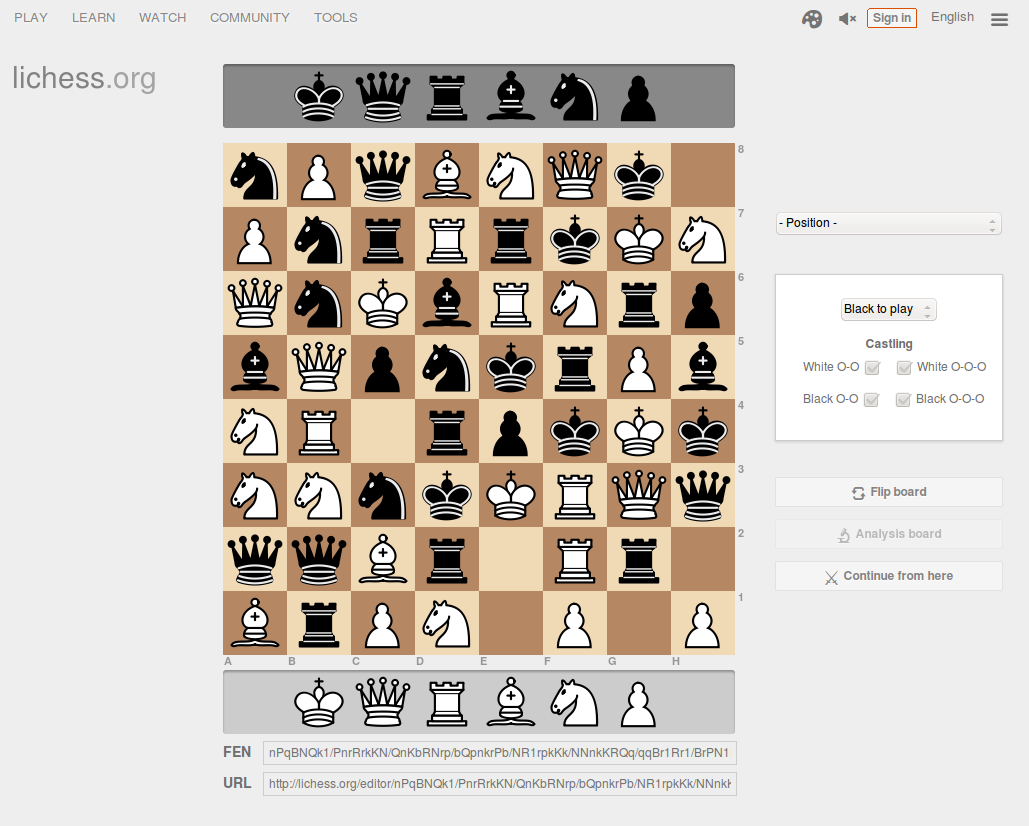

In [19]:
from IPython.display import Image, display
print "FEN:",urlA
display(Image("testA.png"))

Awesome! Since every render will have the same layout we can crop the picture after the fact to hold just the board.

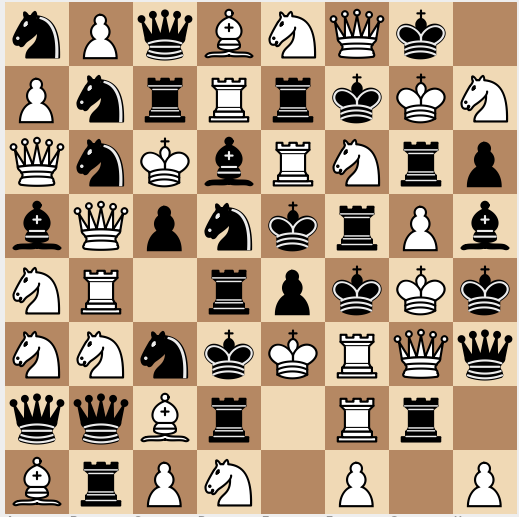

In [20]:
# Crop boundaries
# 218,141
# 737,658
import PIL
im = PIL.Image.open("testA.png")
im = im.crop([218,141,737,658])
im.save("testA_crop.png")
display(Image("testA_crop.png"))

Looks good, now that we can get tight fit images, let's generate a set of images with the FEN encoded in the filename, this will make it easy to generate training data and labels in one go with the computer vision script. This will create a ton of duplicate tiles, since technically there should only be 26 different tiles with all else being equal. However, this sets the stage for loading different themes for board and pieces. It also allows for training for some image boundary bleed-over when tiles are on the edges of the board. Finally, we'll be able to use this for some other sites like chess.com and PGN viewers, etc.

In [21]:
import helper_functions as hf
import PIL

# Number of random screenshots to generate
N = 20

out_folder = 'train_gen_lichess'
hf.createDir(out_folder)

output_filenameA = "testA.png"
output_filenameB = "testB.png"
output_filenames = [output_filenameA, output_filenameB]
for i in range(N):
    # Generate random FEN
    fen = getRandomFEN()
    
    print "#%d : %s" % (i,fen)
    output_filename = "%s/lichess%04d__%s.png" % (out_folder, i, fen.replace('/','-'))
    
    # Render webpage and save screenshot
    status = chessServer.takeChessScreenshot(fen,output_filename)
    
    if status == 0:
        print "\t...Success"
    else:
        print "\tFailed on %s -> %s" % (fen, output_filename)
        break
    
    # Load image, crop and overwrite file
    im = PIL.Image.open(output_filename).crop([218,141,737,658]).save(output_filename)

#0 : pPBBnprr/BBbKbKbQ/K1p1r1bB/prkQbKPQ/1nrKpR1q/B1RpBRKk/KkNkNnqb/Bnkkr1RR
	Saved screenshot to 'train_gen_lichess/lichess0000__pPBBnprr-BBbKbKbQ-K1p1r1bB-prkQbKPQ-1nrKpR1q-B1RpBRKk-KkNkNnqb-Bnkkr1RR.png'
	...Success


## Generate Tile images from screenshots
Great, now that we have several boards, let's generate the tiles for them.

In [13]:
import tensorflow_chessbot as tc
# Directory structure
input_chessboard_folder = 'train_gen_lichess'
output_tile_folder = 'train_tiles_lichess'

tc.generateTileset(input_chessboard_folder, output_tile_folder)

#  1/81 : train_gen_lichess/lichess0077__BRpnRpRk-k1knRbPP-KQBqNBnk-1rbPbBkk-NqKNrQKN-p1qK1PKB-QbnbbKp1-PNR1QNkp.png
---
Loading train_gen_lichess/lichess0077__BRpnRpRk-k1knRbPP-KQBqNBnk-1rbPbBkk-NqKNrQKN-p1qK1PKB-QbnbbKp1-PNR1QNkp.png...
Loaded train_gen_lichess/lichess0077__BRpnRpRk-k1knRbPP-KQBqNBnk-1rbPbBkk-NqKNrQKN-p1qK1PKB-QbnbbKp1-PNR1QNkp.png (519px x 517px)
	Generating tiles for lichess0077__BRpnRpRk-k1knRbPP-KQBqNBnk-1rbPbBkk-NqKNrQKN-p1qK1PKB-QbnbbKp1-PNR1QNkp...
	Saving tiles lichess0077__BRpnRpRk-k1knRbPP-KQBqNBnk-1rbPbBkk-NqKNrQKN-p1qK1PKB-QbnbbKp1-PNR1QNkp
#  2/81 : train_gen_lichess/lichess0025__NrrRkNnN-BbbkNbqQ-BPP1nKbp-1bRKRbpR-1kkPn1p1-nknnnQP1-QN1NRknp-qbK1RQkQ.png
---
Loading train_gen_lichess/lichess0025__NrrRkNnN-BbbkNbqQ-BPP1nKbp-1bRKRbpR-1kkPn1p1-nknnnQP1-QN1NRknp-qbK1RQkQ.png...
Loaded train_gen_lichess/lichess0025__NrrRkNnN-BbbkNbqQ-BPP1nKbp-1bRKRbpR-1kkPn1p1-nknnnQP1-QN1NRknp-qbK1RQkQ.png (519px x 517px)
	Generating tiles for lichess0025__NrrRkNnN-BbbkNbqQ-

Alright, with 50 boards, we have 3200 tiles with the format `lichess<num>__<FEN>_<RANK><FILE>.png`

For example `lichess0000__PkqrBBKq-RKbRpN1q-rKQRpPNN-PQNNPqBQ-Pqr1bbbp-pRbqnbBn-P1qbQQRr-rpBqRQNk_B6.png`

This gives us all the information we need to load a tile and determine it's label within an image.